## Тест модуля восстановления глубины

#### Импортирование общих библиотек и OPR

In [1]:
import sys
sys.path.append('/home/kirill/TopoSLAM/OpenPlaceRecognition/src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from cv2 import imread
from skimage.transform import resize
from scipy.spatial.transform import Rotation

In [3]:
import sys
sys.path.append('/home/kirill/Depth-Anything-V2/')  # локальный путь до кода

import cv2
import torch
import os
import pandas as pd
import numpy as np
import random
import os
import gc
import time
import open3d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import transformers
import cv2.aruco as aruco
import torch.nn.functional as F

from copy import deepcopy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from accelerate import DistributedDataParallelKwargs, Accelerator, notebook_launcher
from accelerate.utils import set_seed
from tqdm import tqdm
from PIL import Image
from depth_anything_v2.dpt import DepthAnythingV2
from metric_depth.depth_anything_v2.dpt import DepthAnythingV2 as DepthAnythingV2Metric
from metric_depth.dataset.transform import Resize, NormalizeImage, PrepareForNet, Crop
from metric_depth.util.loss import SiLogLoss

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


xFormers not available
xFormers not available
xFormers not available
xFormers not available


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from opr.pipelines.depth_estimation import DepthEstimationPipeline

#### Задание нейросети восстановления глубины

In [6]:
sys.path.append('/home/kirill/AdelaiDepth/LeReS/Minist_Test')
from lib.multi_depth_model_woauxi import RelDepthModel
from lib.net_tools import load_ckpt

def parse_args(a):
    parser = argparse.ArgumentParser(
        description='Configs for LeReS')
    parser.add_argument('--load_ckpt', default='./res50.pth', help='Checkpoint path to load')
    parser.add_argument('--backbone', default='resnext101', help='Checkpoint path to load')

    args = parser.parse_args(a)
    return args

import argparse
arguments = "--load_ckpt /home/kirill/AdelaiDepth/weights/res50.pth \
            --backbone resnet50".split()
args = parse_args(arguments)

old_model = RelDepthModel(backbone='resnet50').cuda()
load_ckpt(args, old_model, None, None)

loading checkpoint /home/kirill/AdelaiDepth/weights/res50.pth


In [7]:
MODELS_BASE_PATH = '/home/kirill/Depth-Anything-V2/weights'
#DATA_BASE_PATH = '/media/kirill/7CM/ITLP_campus_bags/dataset/indoor/00_2023-10-25-night/floor_5'
DATA_BASE_PATH = '/media/kirill/7CM/ITLP_campus_bags/dataset/outdoor/03_2023-04-11/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from typing import Tuple

def project_points_to_camera(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, in_image]
    uvw = np.dot(proj_matrix, points[:, in_image])
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1])
    return uv[:, in_image].astype(int), depths[in_image]

In [9]:
model_configs = {
    'small': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'base': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'large': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

In [10]:
type = 'small'
params = model_configs[type]
new_model = DepthAnythingV2Metric(**params, max_depth=20.0)
model_path=os.path.join(MODELS_BASE_PATH, 'depth_anything_v2_metric_vkitti_vits.pth')
new_model.load_state_dict(torch.load(model_path))
new_model.to(DEVICE)

INFO:dinov2:using MLP layer as FFN


DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

#### Задание трансформации между лидаром и камерой (данные из росбэга с робота Husky)

In [11]:
fx = 683.6
fy = fx
cx = 615.1
cy = 345.3
camera_matrix = {'f': fx, 'cx': cx, 'cy': cy}
proj_matrix = np.array([
    [fx, 0.0, cx, 0],
    [0.0, fy, cy, 0],
    [0.0, 0.0, 1.0, 0]
])
rotation = [-0.498, 0.498, -0.495, 0.510]
R = Rotation.from_quat(rotation).as_matrix()
#R = np.linalg.inv(R)
translation = np.array([[0.061], [0.049], [-0.131]])
tf_matrix = np.concatenate([R, translation], axis=1)
tf_matrix = np.concatenate([tf_matrix, np.array([[0, 0, 0, 1]])], axis=0)

In [12]:
tf_matrix.T

array([[ 0.01505794, -0.99977525, -0.01492309,  0.        ],
       [ 0.00888194,  0.01505794, -0.99984717,  0.        ],
       [ 0.99984717,  0.01492309,  0.00910668,  0.        ],
       [ 0.061     ,  0.049     , -0.131     ,  1.        ]])

#### Инициализация модуля восстановления глубины

In [13]:
de_old = DepthEstimationPipeline(old_model, model_type='AdelaiDepth', align_type='average')
de_old.set_camera_matrix(camera_matrix)
de_old.set_lidar_to_camera_transform(tf_matrix)

In [14]:
de_new = DepthEstimationPipeline(new_model, model_type='DepthAnything', align_type='average', mode='outdoor')
de_new.set_camera_matrix(camera_matrix)
de_new.set_lidar_to_camera_transform(tf_matrix)

#### Запуск восстановления глубины

In [15]:
rmses_old = []
rels_old = []
rmses_new = []
rels_new = []

In [16]:
import pandas as pd
from tqdm import tqdm_notebook
zs_all = {}
rel_errors_all = {}
errors_all = {}
for track_dir in ['01_2023-02-21', '03_2023-04-11']:
    DATA_BASE_PATH = '/media/kirill/7CM/ITLP_campus_bags/dataset/outdoor/{}'.format(track_dir)
    track_csv = pd.read_csv(os.path.join(DATA_BASE_PATH, 'track.csv'))
    track_csv['front_cam_ts'] = track_csv['front_cam_ts'].astype(str)
    track_csv['lidar_ts'] = track_csv['lidar_ts'].astype(str)
    zs_all[track_dir] = []
    rel_errors_all[track_dir] = []
    errors_all[track_dir] = []
    for i in tqdm_notebook(range(track_csv.shape[0])):
        ts_cam = track_csv['front_cam_ts'].iloc[i]
        ts_lidar = track_csv['lidar_ts'].iloc[i]
        print(ts_cam, ts_lidar)
        test_img_file = os.path.join(DATA_BASE_PATH, 'front_cam', '{}.png'.format(ts_cam))
        test_cloud_file = os.path.join(DATA_BASE_PATH, 'lidar', '{}.bin'.format(ts_lidar))
        test_img = imread(test_img_file)
        test_img = test_img[:, :, :3]
        test_cloud = np.fromfile(test_cloud_file, dtype=np.float32).reshape((-1, 4))[:, :-1]
        test_cloud = test_cloud[test_cloud == test_cloud].reshape((-1, 3))
        print(test_img.shape)
        print(test_cloud.shape)
        print(test_cloud.min(), test_cloud.max())
        # depth, rmse, rel = de_old.get_depth_with_lidar(test_img, test_cloud[:, :3])
        # rmses_old.append(rmse)
        # rels_old.append(rel)
        # depth, rmse, rel = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        depth, zs, errors, rel_errors = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        rmses_new.append(rmse)
        rels_new.append(rel)
        zs_all[track_dir] += list(zs)
        rel_errors_all[track_dir] += list(rel_errors)
        errors_all[track_dir] += list(errors)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(track_csv.shape[0])):



  0%|          | 0/620 [00:00<?, ?it/s]

1676982539166589 1676982539200253
(720, 1280, 3)
(26568, 3)
-69.35512 55.716537
Inference time: 1.9100911617279053
Max x, y, z: [31.44747976  0.91262288 49.96435019]
cnt: 2445
Scaling: 2.4744923197468633
5.634929355148049 0.1707027802816895
1676982565665289 1676982565622711
(720, 1280, 3)
(25281, 3)
-78.50035 66.14286
Inference time: 0.09604144096374512
Max x, y, z: [33.27825818  0.92026007 49.66315345]
cnt: 2002
Scaling: 2.1573698997487787
6.014739533342272 0.20884956682582537
1676982571448376 1676982571471927
(720, 1280, 3)
(25126, 3)
-65.92891 81.81935
Inference time: 0.10144591331481934
Max x, y, z: [24.01823319  0.96383871 49.98899263]
cnt: 2128
Scaling: 2.071862697427062
5.996731516507841 0.2505014096188186
1676982577748024 1676982577724619
(720, 1280, 3)
(24514, 3)
-112.045364 77.20538
Inference time: 0.1745772361755371
Max x, y, z: [24.5628387   0.90339511 49.72605421]
cnt: 1291
Scaling: 2.4605751635649957
7.823388927744671 0.35677357344143834
1676982582547852 1676982582565304


Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(track_csv.shape[0])):



  0%|          | 0/638 [00:00<?, ?it/s]

1681219119208908 1681219119229792
(720, 1280, 3)
(25701, 3)
-92.23574 64.80349
Inference time: 0.08937191963195801
Max x, y, z: [34.84270007  0.95425531 49.70175054]
cnt: 2226
Scaling: 2.313753288164546
4.979911585358893 0.13348533643938246
1681219138493740 1681219138494514
(720, 1280, 3)
(24479, 3)
-92.30466 57.994534
Inference time: 0.08790063858032227
Max x, y, z: [34.51890457  1.03125938 49.85114839]
cnt: 2312
Scaling: 2.1888241543714146
4.751747270506947 0.15937362048070808
1681219143810825 1681219143840199
(720, 1280, 3)
(24467, 3)
-72.57266 78.95836
Inference time: 0.08859395980834961
Max x, y, z: [25.43044143  0.97430728 49.58231028]
cnt: 2232
Scaling: 1.9980582927657564
4.285982409501022 0.1688787101824256
1681219149811304 1681219149791068
(720, 1280, 3)
(24094, 3)
-91.63545 77.20245
Inference time: 0.0896599292755127
Max x, y, z: [24.36571736  0.88279127 49.84377232]
cnt: 1636
Scaling: 1.7682173728540762
8.008915132548138 0.4591624648008254
1681219155111777 1681219155136777
(

In [17]:
def get_cloud_by_timestamp(data_dir, ts, float32=False):
    stamps = [int(x[:-4]) for x in os.listdir(os.path.join(data_dir, 'lidar'))]
    stamps.sort()
    i = 0
    #if float32:
    #    stamps = np.array(stamps) * 1000
    while i < len(stamps) and stamps[i] < ts:
        i += 1
    #print(i, len(stamps))
    if i == len(stamps):
        stamp = stamps[-1]
    elif i == 0:
        stamp = stamps[0]
    elif ts - stamps[i - 1] < stamps[i] - ts:
        stamp = stamps[i - 1]
    else:
        stamp = stamps[i]
    #print(ts, stamp, ts - stamp)
    if float32:
        return stamp, np.fromfile(os.path.join('dataset', data_dir, 'lidar', '{}.bin'.format(stamp)), 
                           dtype=np.float32).reshape((-1, 4))[:, :-1]
    return stamp, np.fromfile(os.path.join('dataset', data_dir, 'lidar', '{}.bin'.format(stamp))).reshape((-1, 3))

In [18]:
def get_image_by_timestamp(data_dir, ts):
    stamps = [int(x[:-4]) for x in os.listdir(os.path.join(data_dir, 'front_cam'))]
    stamps.sort()
    i = 0
    #if float32:
    #    stamps = np.array(stamps) * 1000
    while i < len(stamps) and stamps[i] < ts:
        i += 1
    #print(i, len(stamps))
    if i == len(stamps):
        stamp = stamps[-1]
    elif i == 0:
        stamp = stamps[0]
    elif ts - stamps[i - 1] < stamps[i] - ts:
        stamp = stamps[i - 1]
    else:
        stamp = stamps[i]
    print(ts, stamp, ts - stamp)
    return stamp, imread(os.path.join(data_dir, 'front_cam', '{}.png'.format(stamp)))

In [19]:
for track_dir in ['05_2023-08-15-day', '07_2023-10-04-day']:
    DATA_BASE_PATH = '/media/kirill/7CM/ITLP_campus_bags/dataset/outdoor/{}'.format(track_dir)
    track_csv = pd.read_csv(os.path.join(DATA_BASE_PATH, 'track_filtered.csv'))
    print(track_csv.shape, track_csv.columns)
    track_csv['timestamp'] = track_csv['timestamp'].astype(int)
    print(track_csv['timestamp'].values)
    zs_all[track_dir] = []
    rel_errors_all[track_dir] = []
    errors_all[track_dir] = []
    for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):
        stamp = track_csv.iloc[i]['timestamp']
        ts_lidar, test_cloud = get_cloud_by_timestamp(DATA_BASE_PATH, stamp)
        ts_cam, test_img = get_image_by_timestamp(DATA_BASE_PATH, stamp)
        test_img = test_img[:, :, :3]
        test_cloud = test_cloud[test_cloud == test_cloud].reshape((-1, 3))
        print(test_img.shape)
        print(test_cloud.shape)
        print(test_cloud.min(), test_cloud.max())
        # depth, rmse, rel = de_old.get_depth_with_lidar(test_img, test_cloud[:, :3])
        # rmses_old.append(rmse)
        # rels_old.append(rel)
        # depth, rmse, rel = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        depth, zs, errors, rel_errors = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        rmses_new.append(rmse)
        rels_new.append(rel)
        zs_all[track_dir] += list(zs)
        rel_errors_all[track_dir] += list(rel_errors)
        errors_all[track_dir] += list(errors)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):



(5300, 11) Index(['Unnamed: 0.1', 'Unnamed: 0', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy',
       'qz', 'qw', 'corrected'],
      dtype='object')
[1692104019422546432 1692104020026534912 1692104020430549504 ...
 1692107737545883648 1692107738251936512 1692107738957915904]


  0%|          | 0/530 [00:00<?, ?it/s]

1692104019422546432 1692104019377483117 45063315
(720, 1280, 3)
(25834, 3)
-93.12130737304688 54.9208869934082
Inference time: 0.09298944473266602
Max x, y, z: [40.54109685  0.97781701 49.82861404]
cnt: 2419
Scaling: 2.3071142869413315
5.951248115377395 0.19014354205595987
1692104025070817280 1692104025088575018 -17757738
(720, 1280, 3)
(24331, 3)
-94.17203521728516 65.45575714111328
Inference time: 0.16093730926513672
Max x, y, z: [34.20800977  0.9520124  49.97080198]
cnt: 2562
Scaling: 2.230650400678276
5.650097853793505 0.23048611928788118
1692104030513783040 1692104030481966897 31816143
(720, 1280, 3)
(24346, 3)
-89.71334075927734 85.8808364868164
Inference time: 0.09070181846618652
Max x, y, z: [25.87542541  0.93390289 49.79463564]
cnt: 1525
Scaling: 1.6880852238634858
8.639606127597665 0.3905986746486791
1692104035761333504 1692104035780382666 -19049162
(720, 1280, 3)
(24848, 3)
-111.66700744628906 82.86141204833984
Inference time: 0.09595227241516113
Max x, y, z: [25.34576994  0

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):



Inference time: 0.08978652954101562
Max x, y, z: [44.06451325  1.40194229 49.04707051]
cnt: 1064
Scaling: 1.907686474792254
15.751547564311759 0.8312571499250045
(6000, 11) Index(['Unnamed: 0.1', 'Unnamed: 0', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy',
       'qz', 'qw', 'corrected'],
      dtype='object')
[1696412232676220928 1696412232877946624 1696412233382264320 ...
 1696415834101690112 1696415834908581632 1696415835513740032]


  0%|          | 0/600 [00:00<?, ?it/s]

1696412232676220928 1696412232656832762 19388166
(720, 1280, 3)
(25418, 3)
-103.74068450927734 75.14258575439453
Inference time: 0.10014152526855469
Max x, y, z: [39.90514692  1.35156953 49.4292615 ]
cnt: 2832
Scaling: 11.685151585373355
9.251113465514987 0.31690207901924483
1696412237920990976 1696412237946628523 -25637547
(720, 1280, 3)
(24461, 3)
-101.6994400024414 73.82656860351562
Inference time: 0.10258626937866211
Max x, y, z: [32.19344945  0.94428628 49.92428495]
cnt: 2747
Scaling: 2.0202261181646235
3.80469063576346 0.1416760558798162
1696412242762285824 1696412242748839065 13446759
(720, 1280, 3)
(24519, 3)
-94.5678482055664 90.71416473388672
Inference time: 0.10213732719421387
Max x, y, z: [22.76156504  0.95858926 49.77884122]
cnt: 1922
Scaling: 1.7763729046103438
4.801263469357186 0.20405652657123724
1696412247603573248 1696412247656016615 -52443367
(720, 1280, 3)
(24805, 3)
-115.92057800292969 82.6323471069336
Inference time: 0.10072565078735352
Max x, y, z: [30.01104721  

In [20]:
rmse_by_z = {}
rel_by_z = {}
for track in zs_all.keys():
    rmse_by_z[track] = []
    rel_by_z[track] = []
    zs = np.array(zs_all[track])
    errors = np.array(errors_all[track])
    rels = np.array(rel_errors_all[track])
    for z in range(0, 50, 5):
        rel = rels[(zs > z) * (zs <= z + 5)].mean()
        rmse = np.sqrt(np.mean(errors[(zs > z) * (zs <= z + 5)] ** 2))
        rel_by_z[track].append(rel)
        rmse_by_z[track].append(rmse)

In [36]:
seasons = {'01':'Winter', '03':'Spring', '05':'Summer', '07':'Autumn'}

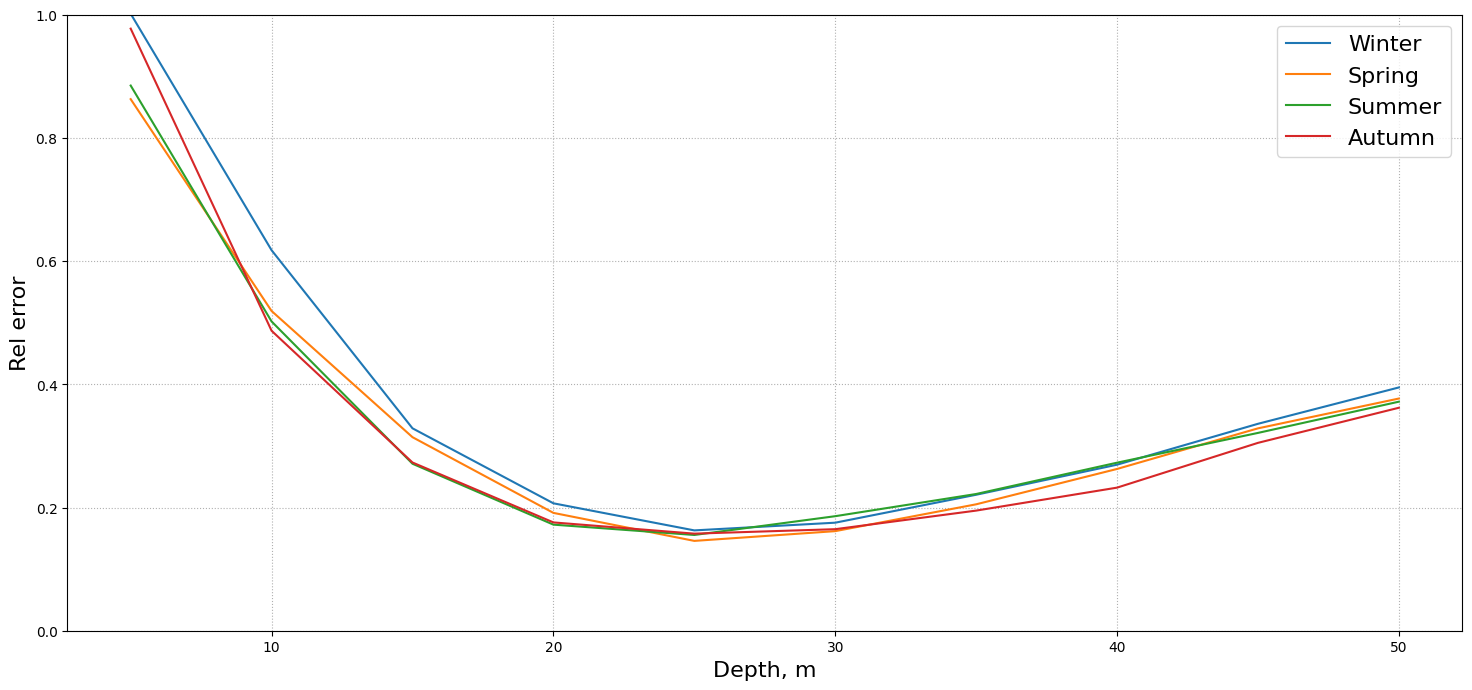

In [42]:
plt.figure(figsize=(18, 8))
plt.grid(ls=':')
for track in zs_all.keys():
    plt.plot(np.linspace(5, 50, 10), rel_by_z[track], label=seasons[track[:2]])
plt.xlabel('Depth, m', fontsize=16)
plt.ylabel('Rel error', fontsize=16)
plt.ylim((0, 1))
plt.legend(fontsize=16)
plt.savefig('rel_errors.png')

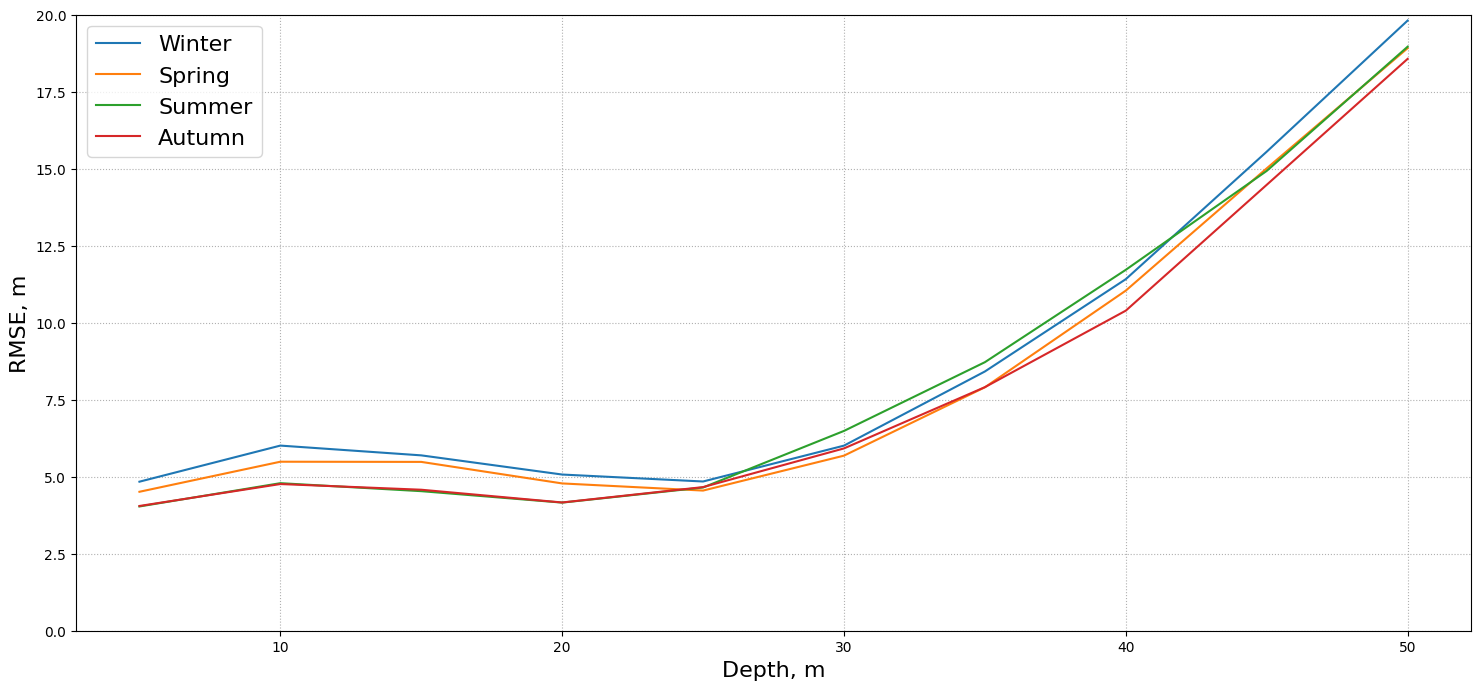

In [43]:
plt.figure(figsize=(18, 8))
plt.grid(ls=':')
for track in zs_all.keys():
    plt.plot(np.linspace(5, 50, 10), rmse_by_z[track], label=seasons[track[:2]])
plt.xlabel('Depth, m', fontsize=16)
plt.ylabel('RMSE, m', fontsize=16)
plt.ylim((0, 20))
plt.legend(fontsize=16)
plt.savefig('rmse.png')

In [23]:
print('RMSE of old model:', np.mean(rmses_old))
print('RMSE of new model:', np.mean(rmses_new))
print('Rel error of old model:', np.mean(rels_old))
print('Rel error of new model:', np.mean(rels_new))

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



RMSE of old model: nan
RMSE of new model: 6.575366958894425
Rel error of old model: nan
Rel error of new model: 0.3249363145400359


#### Визуализация

In [24]:
from typing import Tuple

def project_points_to_camera(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, in_image]
    uvw = np.dot(proj_matrix, points[:, in_image])
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1])
    return uv[:, in_image].astype(int), depths[in_image]

In [25]:
def depths_to_colors(depths: np.ndarray, max_depth: int = 10, cmap: str = "hsv") -> np.ndarray:
    depths /= max_depth
    to_colormap = plt.get_cmap(cmap)
    rgba_values = to_colormap(depths, bytes=True)
    return rgba_values[:, :3].astype(int)

In [26]:
from cv2 import resize
%timeit resize(test_img, (480, 640))

136 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
image_resized = resize(test_img, (640, 480))
image_resized.max()

255

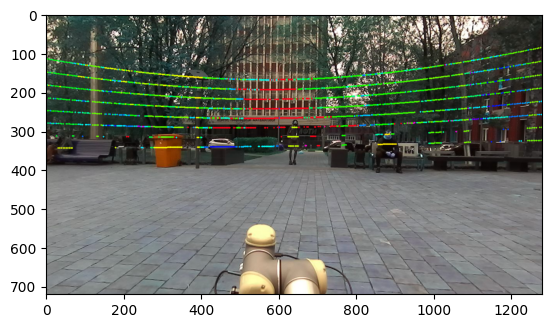

In [28]:
cloud_expanded = np.hstack([test_cloud, np.ones((test_cloud.shape[0], 1))])
b = tf_matrix.T @ cloud_expanded.T
b = b.T[b.T[:, 1] < 0].T
uv, depths = project_points_to_camera(b, proj_matrix, (1280, 720))
rgb_distances = depths_to_colors(depths, max_depth=50)
for point, d in zip(uv.T, rgb_distances):
    c = (int(d[0]), int(d[1]), int(d[2]))
    cv2.circle(test_img, point, radius=2, color=c, thickness=cv2.FILLED)
plt.imshow(test_img)

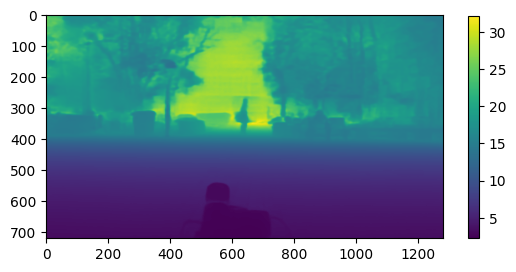

In [29]:
plt.imshow(depth)
plt.colorbar(shrink=0.6)

#### Создание облака точек по восстановленной глубине методом обратной проекции

In [30]:
h, w = depth.shape
def get_point_cloud_from_depth(depth, f, cx, cy):
    print(depth.shape, f, cx, cy)
    i = np.tile(np.arange(h), w).reshape((w, h)).T
    j = np.tile(np.arange(w), h).reshape((h, w))
    z = depth.ravel()
    x = (j.ravel() - cx) / f * z
    y = (i.ravel() - cy) / f * z
    pcd = np.zeros((x.shape[0], 3))
    pcd[:, 0] = x
    pcd[:, 1] = y
    pcd[:, 2] = z
    return pcd

pcd = get_point_cloud_from_depth(depth, camera_matrix['f'], camera_matrix['cx'], camera_matrix['cy'])

(720, 1280) 683.6 615.1 345.3


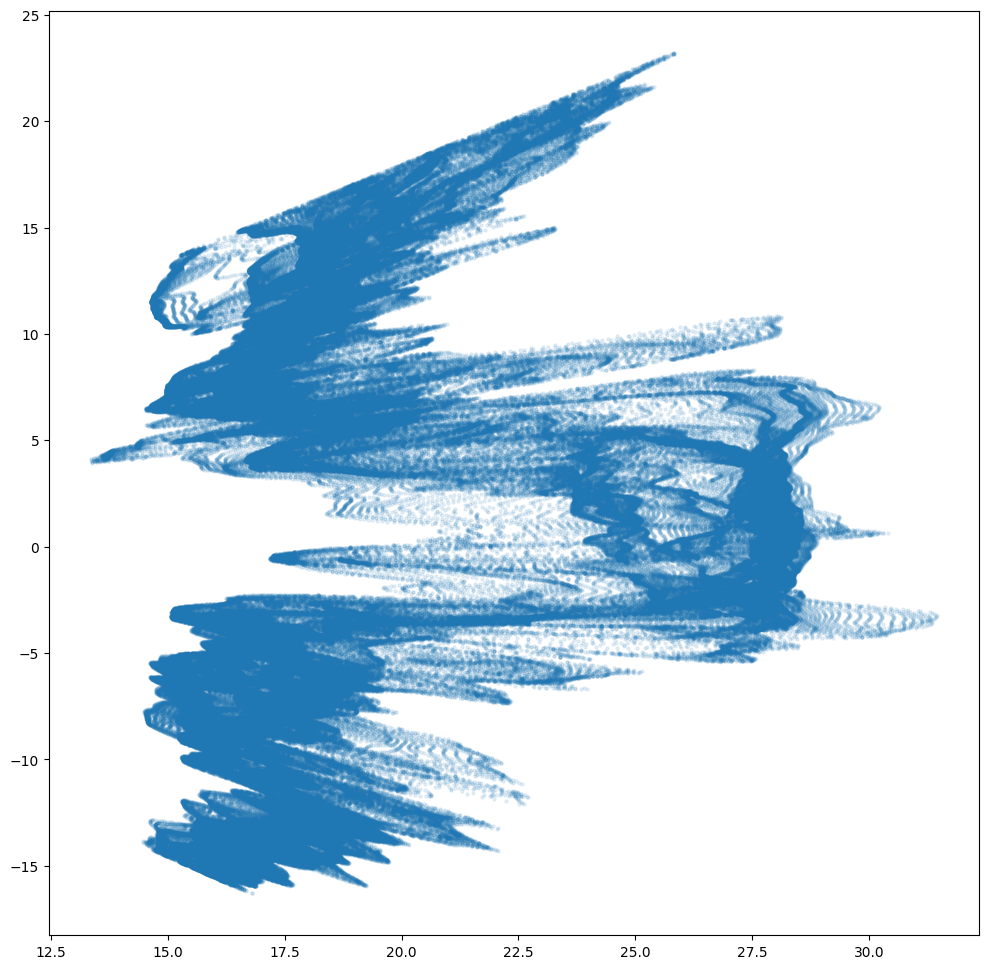

In [31]:
plt.figure(figsize=(12, 12))
plt.scatter(pcd[:, 2][pcd[:, 1] < 0.], -pcd[:, 0][pcd[:, 1] < 0.], s=5, alpha=0.1)

#### Сравнение восстановленного и лидарного облака

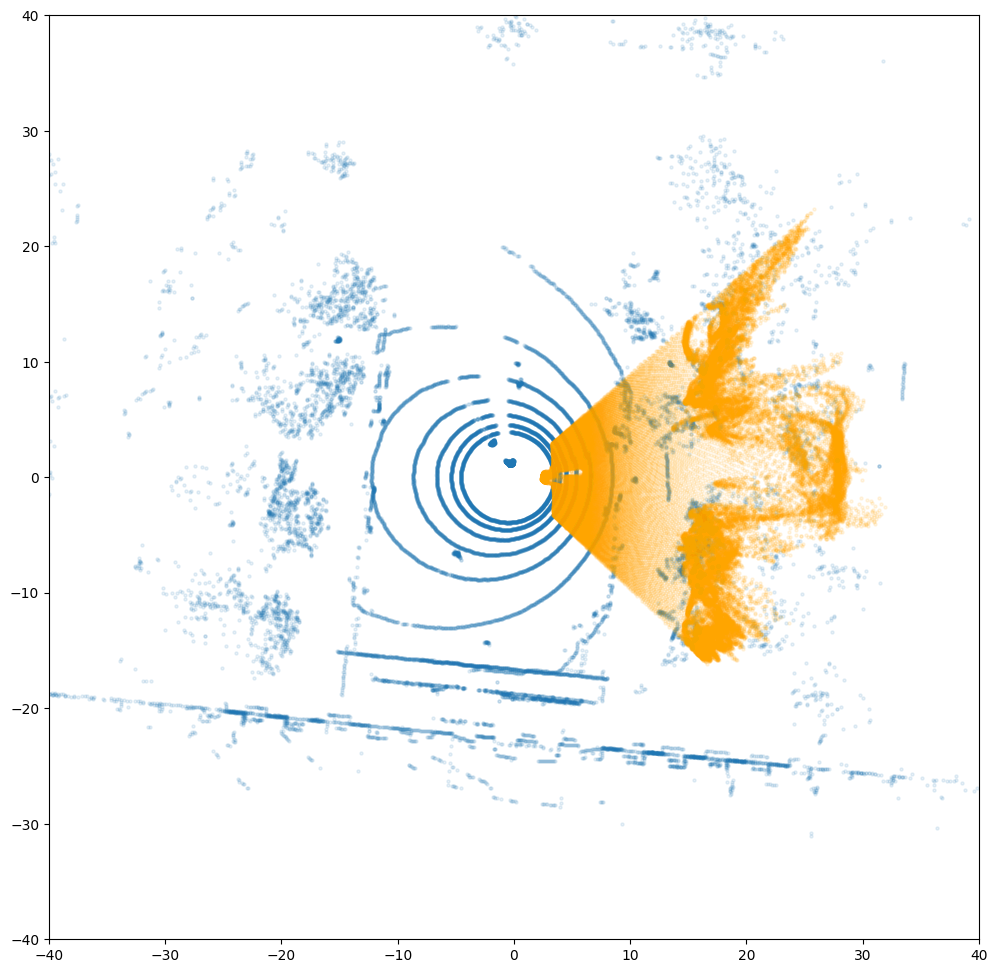

In [32]:
plt.figure(figsize=(12, 12))
plt.xlim((-40, 40))
plt.ylim((-40, 40))
plt.scatter(test_cloud[:, 0], test_cloud[:, 1], s=5, alpha=0.1)
#plt.scatter(test_cloud[:, 0][test_cloud[:, 2] > 0], test_cloud[:, 1][test_cloud[:, 2] > 0], s=5, alpha=0.1)
plt.scatter(pcd[::17, 2], -pcd[::17, 0], color='orange', s=5, alpha=0.1)
plt.savefig('pointcloud_from_nn_depth.png')